In [1]:
import datetime as dt

import numpy as np
import xarray as xr
from xarray.backends import NetCDF4DataStore
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import generic_filter

from siphon.catalog import TDSCatalog
from metpy.units import units
%matplotlib inline

In [2]:
def obtain_narr_access():
    url = 'http://atlas.niu.edu:8080/thredds/catalog/grib/NARR/catalog.xml'
    cat = TDSCatalog(url)
    cat_ds = cat.datasets['Full Collection Dataset']
    subset_access = cat_ds.subset()
    return subset_access

In [3]:
def obtain_dataset(access, name, level, box, wanted_dt):
    query = access.query()
    query.variables(name)
    query.vertical_level(level)
    query.lonlat_box(*box)
    query.time(wanted_dt)
    query.accept('netcdf4')
    
    nc = access.get_data(query)
    ds = xr.open_dataset(NetCDF4DataStore(nc))
    dat = ds.metpy.parse_cf(name)
    return dat

In [4]:
def get_narr_proj_info(ds):
    proj = ds.metpy.cartopy_crs
    x = ds.metpy.x
    y = ds.metpy.y
    return proj, x, y

In [5]:
def get_time_range(center, r):
    times = (center + dt.timedelta(i) for i in range(-r, r+1))
    return times

In [7]:
def get_grid_at_time(data, access, t):
    name = 'Temperature_height_above_ground'
    box = (-125, -75, 20, 55)
    try:
        res = data[t].copy()
    except KeyError:
        ds = obtain_dataset(access, name, 2., box, t)
        data[t] = ds[0,0,:].copy()
        res = data[t].copy()
    return res, data

In [8]:
def compute_mean(access, data, center, n):
    plusminus = n // 2
    times = list(get_time_range(center, plusminus))
    
    running_tot, data = get_grid_at_time(data, access, times[0])

    for t in times[1:]:
        grid, data = get_grid_at_time(data, access, t)
        running_tot += grid
    
    res = running_tot / n
    return res, data

In [9]:
narr_access = obtain_narr_access()

In [10]:
first_date = dt.datetime(1979, 1, 3, 0)
last_date = dt.datetime(2018, 12, 29, 0)
temp_store = {}

In [ ]:
# NARR is roughly 32 km grid spacing.  Determine number of gridpoints equal to 1000 km
s = 1000 // 32

biggest_inc = 0
i = 0

In [20]:
# Restart
first_date = dt.datetime(2017,1,4,0)

# Note: January 1, 2015 and January 1, 2017 are missing from the dataset

In [21]:
d = first_date
while d < last_date:
    mean1, temp_store = compute_mean(narr_access, temp_store, d, 5)
    mean2, temp_store = compute_mean(narr_access, temp_store, d+dt.timedelta(5), 5)
    change = mean2 - mean1
    smooth_change = generic_filter(change, np.mean, size=s, mode='constant')
    max_inc = np.nanmax(smooth_change)
    if max_inc > biggest_inc:
        print('New warmup:', d, max_inc)
        biggest_inc = max_inc
        biggest_info = (mean1, mean2, smooth_change, d)
    d += dt.timedelta(1)
    i += 1
    if i % 50 == 0:
        print(d)

2017-02-02 00:00:00
2017-03-24 00:00:00
2017-05-13 00:00:00
2017-07-02 00:00:00
2017-08-21 00:00:00
2017-10-10 00:00:00
2017-11-29 00:00:00
2018-01-18 00:00:00
2018-03-09 00:00:00
2018-04-28 00:00:00
2018-06-17 00:00:00
2018-08-06 00:00:00
2018-09-25 00:00:00
2018-11-14 00:00:00


HTTPError: Error accessing http://atlas.niu.edu:8080/thredds/ncss/grid/grib/NARR/TP?var=Temperature_height_above_ground&time=2019-01-02T00%3A00%3A00&west=-125&east=-75&south=20&north=55&vertCoord=2.0&accept=netcdf4
Server Error (400: Requested time 2019-01-02T00:00:00Z does not intersect actual time range 1979-01-01T00:00:00Z - 2019-01-01T00:00:00Z)

In [22]:
data_proj, lon, lat = get_narr_proj_info(temp_store[first_date])

In [23]:
def plot_background(ax):
    ax.set_extent((-125, -73, 25, 52), crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

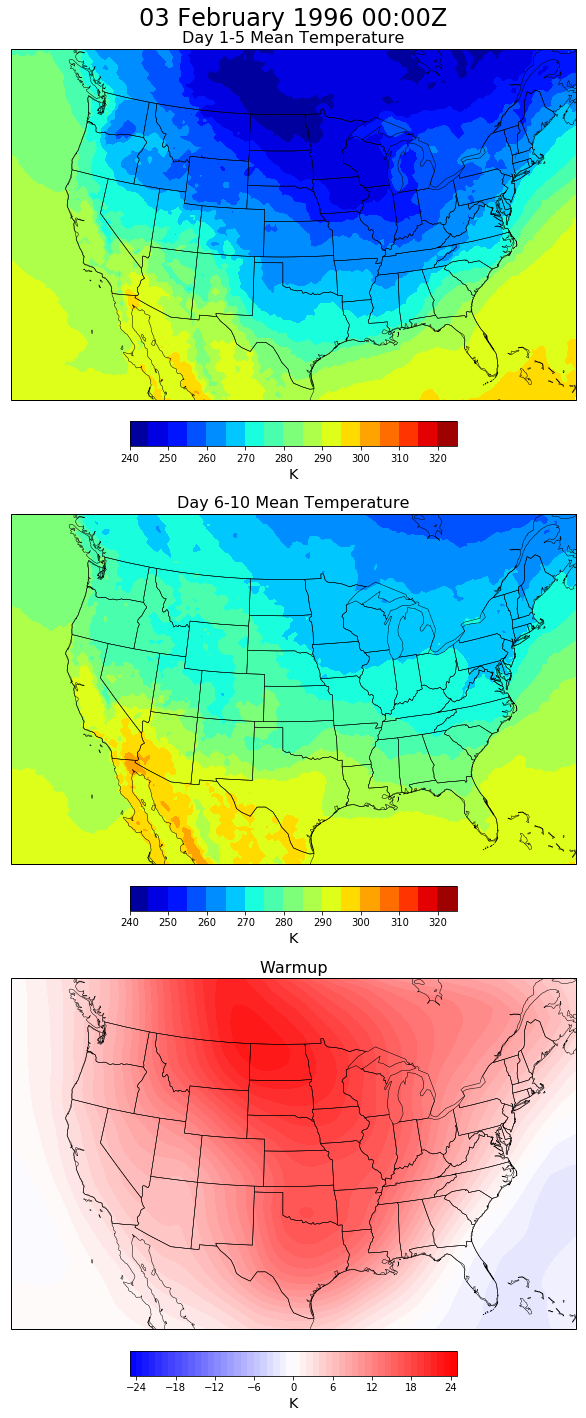

In [25]:
crs = ccrs.LambertConformal(central_longitude=-100)
fig, axarr = plt.subplots(nrows=3, ncols=1, figsize=(13, 20), constrained_layout=True,
                          subplot_kw={'projection': crs})

for ax in axarr:
    plot_background(ax)

levels = np.arange(240,330,5)
    
cf1 = axarr[0].contourf(lon, lat, biggest_info[0], cmap='jet', transform=data_proj, levels=levels)
axarr[0].set_title('Day 1-5 Mean Temperature', fontsize=16)
cb1 = fig.colorbar(cf1, ax=axarr[0], orientation='horizontal', shrink=0.35, pad=0)
cb1.set_label('K', size='x-large')

cf2 = axarr[1].contourf(lon, lat, biggest_info[1], cmap='jet', transform=data_proj, levels=levels)
axarr[1].set_title('Day 6-10 Mean Temperature', fontsize=16)
cb2 = fig.colorbar(cf2, ax=axarr[1], orientation='horizontal', shrink=0.35, pad=0)
cb2.set_label('K', size='x-large')

levels = np.arange(-25,26,1)
cf3 = axarr[2].contourf(lon, lat, biggest_info[2], cmap='bwr', transform=data_proj, levels=levels)
axarr[2].set_title('Warmup', fontsize=16)
cb3 = fig.colorbar(cf3, ax=axarr[2], orientation='horizontal', shrink=0.35, pad=0)
cb3.set_label('K', size='x-large')

fig.set_constrained_layout_pads(w_pad=0., h_pad=0.1, hspace=0., wspace=0.)
fig.suptitle(biggest_info[3].strftime('%d %B %Y %H:%MZ'), fontsize=24)

plt.show()